# Topic : HOMEWORK-4
<img src="https://www.tribloom.com/wp-content/uploads/2019/08/CRISP-DM_Process_Diagram-768x769.png" height=300>

Follow the CRSIP-DM method
1. Step 1: Import library, import data
2. Step 2: Pre-processing (missing data, categorical type, normalization, format transform, data augmentation)
3. Step 3: Build ML Model
4. Step 4: Evaluate Model
5. Step 5: Deploy (Prediction)


## Step 1: Load data (also import library)

In [1]:
!pip install torch torchvision
!pip install Pillow 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# import library
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms, models

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
# get data  (HW4要找一個github,裡面有dataset的folder)
#!git clone https://github.com/jaddoescad/ants_and_bees.git
!git clone https://github.com/laxmimerit/dog-cat-full-dataset.git
# !rm -rf ./woman-man-recog/
# !rm -rf ./GenderRecognizer//


Cloning into 'dog-cat-full-dataset'...
remote: Enumerating objects: 25027, done.
remote: Total 25027 (delta 0), reused 0 (delta 0), pack-reused 25027
Receiving objects: 100% (25027/25027), 541.62 MiB | 32.97 MiB/s, done.
Resolving deltas: 100% (5/5), done.
Checking out files: 100% (25001/25001), done.


In [4]:
!ls ./dog-cat-full-dataset/data/train/

cats  dogs


# Step 2: Pre-process X, Y
* format transform (轉換成numpy format)
* missing data (imputation)差補
* category data transform 
* data augmentation
* normalization


In [5]:
transform_train = transforms.Compose([transforms.Resize((224,224)),
          transforms.RandomHorizontalFlip(),
          transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
          transforms.ColorJitter(brightness=1, contrast=1, saturation=1),
          transforms.ToTensor(),
          transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
          ])


transform = transforms.Compose([transforms.Resize((224,224)),
transforms.ToTensor(),
transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

training_dataset = datasets.ImageFolder('dog-cat-full-dataset/data/train/', transform=transform)
validation_dataset = datasets.ImageFolder('dog-cat-full-dataset/data/train/', transform=transform)

training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=20, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = 20, shuffle=False)


In [6]:
print(len(training_dataset))
print(len(validation_dataset))

20000
20000


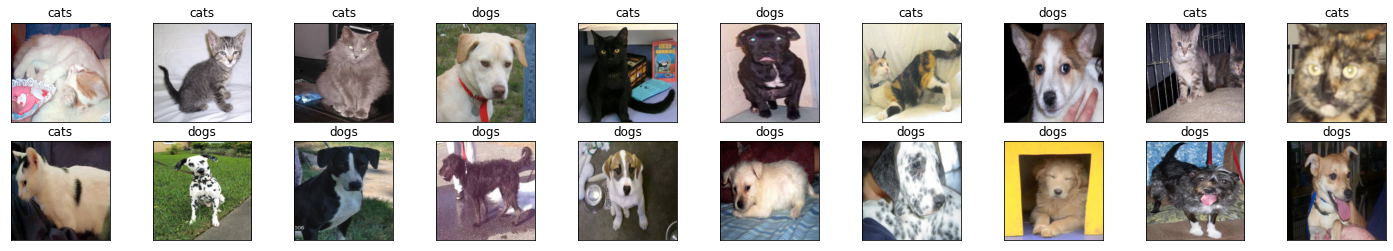

In [27]:
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

# !ls ./Face-Mask-Detection/dataset/

classes=('cats','dogs')

dataiter = iter(training_loader)
images,labels = dataiter.next()
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title(classes[labels[idx].item()])

**!!!注意類別順序，第一次將順序顛倒，導致最後step5判別錯誤，修改後就正確了!**


# Step 3: Build Model for training

<img src="https://ithelp.ithome.com.tw/upload/images/20171206/20001976yeCo1PvEOs.jpg" width=500 />

In [28]:
model = models.vgg16(pretrained=True)
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [29]:
# turn off gradient for all parameters in features extraction 
for param in model.features.parameters():
  param.requires_grad = False

# modify last node from 1000 to 2 
# import torch.nn as nn
n_inputs = model.classifier[6].in_features
last_layer = nn.Linear(n_inputs, len(classes))
model.classifier[6] = last_layer
model.to(device)
print(model)

print("output features=",model.classifier[6].out_features)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

# Step 4: Training Model

In [30]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

In [31]:
epochs = 2
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):
  
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0
  
  for inputs,labels in training_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)

  else:
    with torch.no_grad():
      for val_inputs, val_labels in validation_loader:
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)
        
        _, val_preds = torch.max(val_outputs, 1)
        val_running_loss += val_loss.item()
        val_running_corrects += torch.sum(val_preds == val_labels.data)
      
    epoch_loss = running_loss/len(training_loader.dataset)
    epoch_acc = running_corrects.float()/ len(training_loader.dataset)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)
    
    val_epoch_loss = val_running_loss/len(validation_loader.dataset)
    val_epoch_acc = val_running_corrects.float()/ len(validation_loader.dataset)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)
    print('epoch :', (e+1))
    print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
    print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))


epoch : 1
training loss: 0.0035, acc 0.9753 
validation loss: 0.0014, validation acc 0.9896 
epoch : 2
training loss: 0.0017, acc 0.9893 
validation loss: 0.0005, validation acc 0.9969 


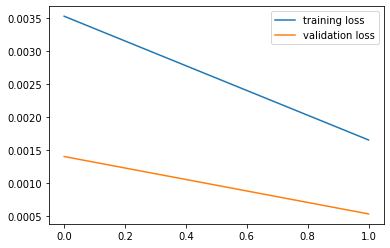

In [32]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

## Step 5 Testing
### dog
<img src="https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/golden-retriever-royalty-free-image-506756303-1560962726.jpg?crop=1.00xw:0.756xh;0,0.0756xh&resize=980:*" alt="dogs" width="300"/>


### cat
<img src="https://i.epochtimes.com/assets/uploads/2021/08/id13156667-shutterstock_376153318-600x400.jpg" alt="cats" width="300"/>

In [33]:
!pip3 install pillow==4.0.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [34]:
import PIL.ImageOps

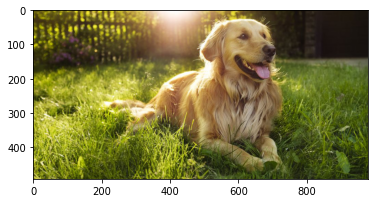

In [38]:
import requests
from PIL import Image

url = 'https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/golden-retriever-royalty-free-image-506756303-1560962726.jpg?crop=1.00xw:0.756xh;0,0.0756xh&resize=980:*'
# url ='https://i.epochtimes.com/assets/uploads/2021/08/id13156667-shutterstock_376153318-600x400.jpg'
# url='https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/golden-retriever-royalty-free-image-506756303-1560962726.jpg?crop=1.00xw:0.756xh;0,0.0756xh&resize=980:*'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)

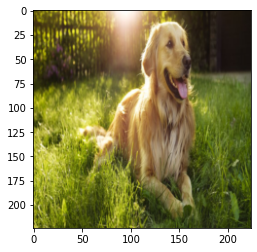

In [39]:
img = transform(img) 
plt.imshow(im_convert(img))

In [37]:
image = img.to(device).unsqueeze(0)
output = model(image)
_, pred = torch.max(output, 1)
print(classes[pred.item()])

dogs


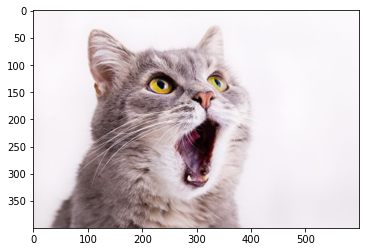

In [40]:
import requests
from PIL import Image

# url = 'https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/golden-retriever-royalty-free-image-506756303-1560962726.jpg?crop=1.00xw:0.756xh;0,0.0756xh&resize=980:*'
url ='https://i.epochtimes.com/assets/uploads/2021/08/id13156667-shutterstock_376153318-600x400.jpg'
# url='https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/golden-retriever-royalty-free-image-506756303-1560962726.jpg?crop=1.00xw:0.756xh;0,0.0756xh&resize=980:*'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)

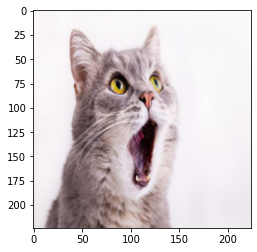

In [41]:
img = transform(img) 
plt.imshow(im_convert(img))

In [42]:
image = img.to(device).unsqueeze(0)
output = model(image)
_, pred = torch.max(output, 1)
print(classes[pred.item()])

cats
